In [34]:
import math
from pprint import pprint
import random

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

random.seed(42)

%matplotlib inline

In [35]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')
# device = torch.device('cpu')

Using CUDA


In [36]:
words = open('names.txt', 'r').read().splitlines()

In [37]:
chars = sorted(list(set(str().join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [38]:
CHARACTERS_SIZE = len(itos)
BLOCK_SIZE = 5
EMBEDDING_SIZE = 15
HIDDEN_LAYER_SIZE = 300
BLOCK_EMBEDDING_SIZE = BLOCK_SIZE * EMBEDDING_SIZE
BATCH_SIZE = 1000
NUMBER_OF_ITERATIONS = 30_000
LEARNING_RATE = 1
DECAYED_LEARNING_RATE = 0.01

In [39]:
def build_dataset(words, block_size):
    X_data, Y_data = [], []
    for word in words:
        context = [0 for _ in range(block_size)]
        for ch in word + '.':
            ix = stoi[ch]

            X_data.append(context)
            Y_data.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X_data, device=device)
    Y = torch.tensor(Y_data, device=device)
    return X, Y

In [40]:
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1], BLOCK_SIZE)
X_dev, Y_dev = build_dataset(words[n1:n2], BLOCK_SIZE)
X_te, Y_te = build_dataset(words[n1:], BLOCK_SIZE)

X_tr = X_tr.to(device)
Y_tr = Y_tr.to(device)
X_dev = X_dev.to(device)
Y_dev = Y_dev.to(device)
X_te = X_te.to(device)
Y_te = Y_te.to(device)

In [41]:
# Parameters
g = torch.Generator(device=device).manual_seed(2147483647)
C = torch.randn((CHARACTERS_SIZE, EMBEDDING_SIZE), generator=g, device=device)
W1 = torch.randn((BLOCK_EMBEDDING_SIZE, HIDDEN_LAYER_SIZE), generator=g, device=device)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g, device=device)
W2 = torch.randn((HIDDEN_LAYER_SIZE, CHARACTERS_SIZE), generator=g, device=device)
b2 = torch.randn(CHARACTERS_SIZE, generator=g, device=device)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

lossi = []

for k in range(NUMBER_OF_ITERATIONS):
    # Batch
    batch_ix = torch.randint(0, X_tr.shape[0], (BATCH_SIZE,), device=device)

    # Forward pass
    emb = C[X_tr[batch_ix]]
    h = torch.tanh(emb.view(-1, BLOCK_EMBEDDING_SIZE) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[batch_ix])

    # lossi.append(loss.item())

    if k % 1000 == 0:
        print(f'Iteration: {k}, loss: {loss.item():.4f}')

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update parameters
    lr = LEARNING_RATE if k < NUMBER_OF_ITERATIONS / 2 else DECAYED_LEARNING_RATE
    for p in parameters:
        p.data += -lr * p.grad

Number of parameters: 31332
Iteration: 0, loss: 34.6125
Iteration: 1000, loss: 8.4010
Iteration: 2000, loss: 7.2904
Iteration: 3000, loss: 6.2258
Iteration: 4000, loss: 3.7315
Iteration: 5000, loss: 3.4701
Iteration: 6000, loss: 3.3460
Iteration: 7000, loss: 2.6452
Iteration: 8000, loss: 2.6507
Iteration: 9000, loss: 2.6758
Iteration: 10000, loss: 2.7409
Iteration: 11000, loss: 2.2951
Iteration: 12000, loss: 2.3442
Iteration: 13000, loss: 2.5422
Iteration: 14000, loss: 2.2609
Iteration: 15000, loss: 2.2556
Iteration: 16000, loss: 1.9796
Iteration: 17000, loss: 1.9593
Iteration: 18000, loss: 1.9788
Iteration: 19000, loss: 1.9415
Iteration: 20000, loss: 1.9475
Iteration: 21000, loss: 1.9516
Iteration: 22000, loss: 1.9655
Iteration: 23000, loss: 1.9702
Iteration: 24000, loss: 1.9346
Iteration: 25000, loss: 1.9618
Iteration: 26000, loss: 1.9035
Iteration: 27000, loss: 1.9634
Iteration: 28000, loss: 1.8850
Iteration: 29000, loss: 1.9772


In [42]:
emb = C[X_tr]
h = torch.tanh(emb.view(-1, BLOCK_EMBEDDING_SIZE) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
print(f'Training set loss: {loss:.4f}')
emb = C[X_dev]
h = torch.tanh(emb.view(-1, BLOCK_EMBEDDING_SIZE) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
print(f'Development set loss: {loss:.4f}')

Training set loss: 1.9556
Development set loss: 2.0936


Text(0, 0.5, 'Loss')

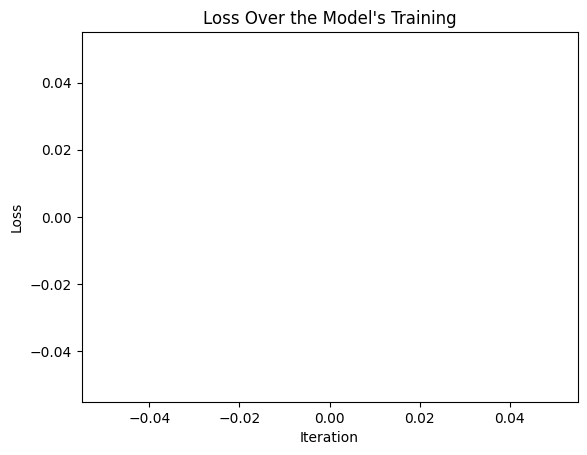

In [43]:
plt.figure()
plt.plot([math.log10(l) for l in lossi])
plt.title('Loss Over the Model\'s Training')
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [44]:
g = torch.Generator(device=device).manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0 for _ in range(BLOCK_SIZE)]
    while True:
        emb = C[torch.tensor([context], device=device)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(str().join(itos[i] for i in out))

kheden.
wyland.
yulanoma.
analiah.
shyamar.
oluwaf.
gurnimier.
zay.
ermald.
candilynn.
evey.
khyas.
haydein.
sheloext.
tette.
sanish.
malya.
avauyanna.
jayset.
kailon.
